In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ndcg_score
from scipy.stats import spearmanr
from sklearn.metrics import average_precision_score
from pathlib import Path
import re

In [ ]:
PATH_FOLDER = Path('giacomelli_esm2_t33_650M_UR50D_RF1k')
LOG_NAME = "giacomelli_mean_metrics_esm2"
reference = pd.read_csv('giacomelli_ref.csv')
k_value = 10
cutoff = 1
aggregate_metrics = True
plotting_spearman = True
graph_title = 'whatever'

In [3]:
#Load reference/labels dataframe and add shifted score and binary columns for future mapping
reference['score_shifted'] = reference['score'] - reference['score'].min()
reference['binary_true'] = [1 if x > cutoff else 0 for x in reference['score']]
print(f"minimum value {reference['score'].min()}")
print(f"maximum value {reference['score'].max()}")
print(f"minimum_shifted {reference['score_shifted'].min()}")
print(f"maximum_shifted {reference['score_shifted'].max()}")
#reference.head(10)
reference.sort_values(by='score' , ascending=False)

minimum value -3.943922005
maximum value 2.533066897
minimum_shifted 0.0
maximum_shifted 6.476988902


,hgvs_pro,score,activity_scaled,score_shifted,binary_true
2225,A119E,2.533067,1.000000,6.476989,1
628,P34C,2.099894,0.933121,6.043816,1
7017,S371H,1.971965,0.913370,5.915887,1
7440,D393P,1.950754,0.910095,5.894676,1
7210,K381M,1.916446,0.904798,5.860368,1
...,...,...,...,...,...
2076,L111G,-3.010790,0.144069,0.933132,0
3159,H168G,-3.088137,0.132127,0.855785,0
4017,R213K,-3.231805,0.109946,0.712117,0
2244,K120D,-3.624908,0.049253,0.319014,0


In [4]:
rows = []
for z in range(1,4):
    for i in range(1, 11):
        if not PATH_FOLDER.exists():
            print('Check path')
                
            break
            
        else:
            df_sorted_all = pd.read_csv( PATH_FOLDER / f'REPL{z}' / f'Round{i}' / 'df_sorted_all.csv')

            #Prepare suggested dataframe, adding true scores and binary labels

            suggested = df_sorted_all[['variant' , 'y_pred']].copy()
            
            #Map true shifted scores and binary labels
            suggested['y_score'] = suggested['variant'].map(reference.set_index('hgvs_pro')['score_shifted'])
            suggested['binary_true'] = suggested['variant'].map(reference.set_index('hgvs_pro')['binary_true'])
            suggested['binary_predicted'] = [1 if x > cutoff else 0 for x in suggested['y_pred']]

            #Sort by predicted scores
            suggested.sort_values(by='y_pred', ascending=False, inplace=True)
            #Reset index, just in case
            suggested.reset_index(drop=True, inplace=True)

            #Reshape for nDCG
            y_true = suggested['y_score'].values.reshape(1, -1)
            y_score = suggested['y_pred'].values.reshape(1, -1)

            #nDCG@k
            ndcg = ndcg_score(y_true , y_score , k=k_value)


            #Spearman/p-value
            rho, pval = spearmanr(suggested['y_score'], suggested['y_pred'])

            #mAP
            AP = average_precision_score(suggested['binary_true'] , suggested['y_pred'])
            
            row_log = {'': f'Round{i}', f'nDCG@k={k_value}' : ndcg ,'Spearman_rho': rho, 'Spearman_pval': pval, 'AP' : AP }

            rows.append(row_log)
metrics_df = pd.DataFrame(rows)

if aggregate_metrics is False:
#Output df contains nDCG@k, Spearman rho and p-value, MCC for each round
    metrics_df.to_csv(LOG_NAME + '.csv', index=False)

In [ ]:
metrics_agg = metrics_df.groupby('').agg(nDCG_mean=(f'nDCG@k={k_value}' , 'mean'), nDCG_std=(f'nDCG@k={k_value}' , 'std') , spearman_mean=('Spearman_rho' , 'mean') , spearman_std=('Spearman_rho' , 'std'), mAP=('AP' , 'mean'), AP_std=('AP' , 'std')).reset_index()
metrics_agg['round_n'] = metrics_agg[''].apply(lambda x : int(re.search(r'\d+' , x).group()))
metrics_agg.sort_values(by='round_n', inplace=True)


metrics_agg.to_csv(LOG_NAME + '_aggregate.csv', index=False)

In [ ]:
#spearman graph - lineplot 
#check whether you have both aggregate dfs, otherwise


color=sns.color_palette("Set2")


plt.figure(figsize=(12,6))
boltz_spearman_mean = mean_df_boltz['mean_spearman']
boltz_spearman_std = mean_df_boltz['std_spearman']
esm_spearman_mean = mean_df_esm['mean_spearman']
esm_spearman_std = mean_df_esm['std_spearman']

#Boltz data
plt.plot(range(1,11) , boltz_spearman_mean , label='Spearman@k boltz2', color=color[3] , marker='^')
plt.fill_between(range(1,11), boltz_spearman_mean - boltz_spearman_std , boltz_spearman_mean + boltz_spearman_std , color=color[3], alpha=0.2)


#ESM data
plt.plot(range(1,11) , esm_spearman_mean , label='Spearman@k esm2', color=color[1] , marker='^')
plt.fill_between(range(1,11), esm_spearman_mean - esm_spearman_std , esm_spearman_mean + esm_spearman_std , color=color[1], alpha=0.2)


plt.title(graph_title , fontsize=10)
plt.xticks(range(1,11))
plt.xlabel('Round')
plt.legend()
plt.ylim(-1,1)
plt.xlim(0.8 , 10.2)

if plotting_spearman is True:
    plt.yticks([-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])
    plt.savefig(LOG_NAME + 'spearman_rho.png' , dpi=400)
    plt.show()
else:
    plt.yticks([0.4,0.6,0.8,1])
    plt.savefig(LOG_NAME + 'nDCG@K.png' , dpi=400)
    plt.show()


NameError: name 'mean_df_boltz' is not defined

<Figure size 1200x600 with 0 Axes>

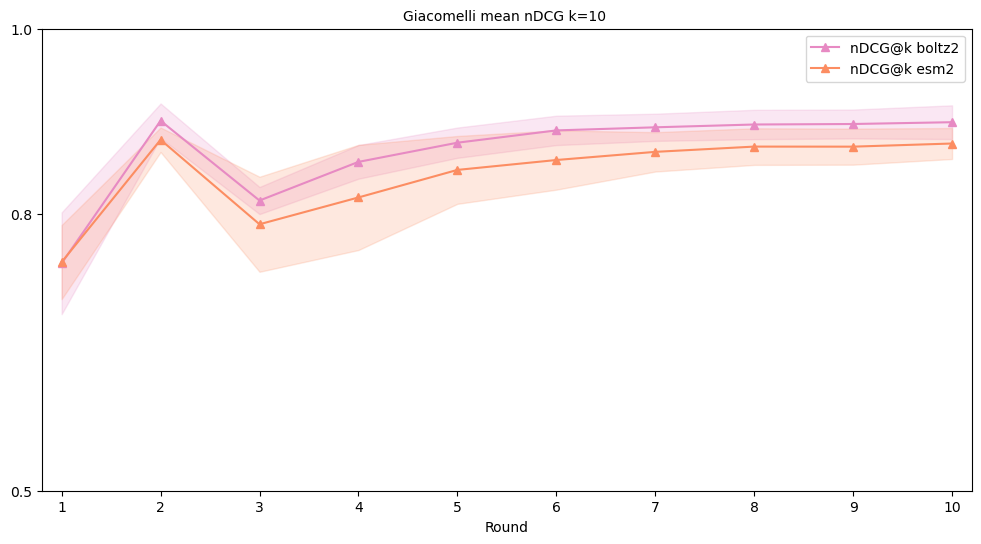

In [195]:
#nDCG@k graph - lineplot


color=sns.color_palette("Set2")


plt.figure(figsize=(12,6))
boltz_spearman_mean = mean_df_boltz['mean_nDCG']
boltz_spearman_std = mean_df_boltz['std_nDCG']
esm_spearman_mean = mean_df_esm['mean_nDCG']
esm_spearman_std = mean_df_esm['std_nDCG']

#Boltz data
plt.plot(range(1,11) , boltz_spearman_mean , label='nDCG@k boltz2', color=color[3] , marker='^')
plt.fill_between(range(1,11), boltz_spearman_mean - boltz_spearman_std , boltz_spearman_mean + boltz_spearman_std , color=color[3], alpha=0.2)


#ESM data
plt.plot(range(1,11) , esm_spearman_mean , label='nDCG@k esm2', color=color[1] , marker='^')
plt.fill_between(range(1,11), esm_spearman_mean - esm_spearman_std , esm_spearman_mean + esm_spearman_std , color=color[1], alpha=0.2)

#plt.errorbar(range(1,11), mean_df_boltz['mean_spearman'], yerr=mean_df_boltz['std_spearman'], label='Spearman@k boltz2', color=color[3], marker='^', capsize=3)
#plt.errorbar(range(1,11), mean_df_esm['mean_spearman'], yerr=mean_df_esm['std_spearman'], label='Spearman@k esm2', color=color[1], marker='o', capsize=3)

plt.title('Giacomelli mean nDCG k=10 ' , fontsize=10)
plt.xticks(range(1,11))
plt.xlabel('Round')
plt.legend()
plt.ylim(0.5,1)
plt.xlim(0.8 , 10.2)
#plt.yticks([-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])

plt.yticks([0.5,0.8,1])

plt.savefig(Path(LOG_NAME).stem + '.png' , dpi=400)

plt.show()

In [260]:
SAP_boltz2 = spearman_AP_boltz_df.groupby('').agg(spearman_mean=('Spearman_rho' , 'mean') , spearman_std=('Spearman_rho' , 'std'), mAP=('AP' , 'mean'), AP_std=('AP' , 'std')).reset_index()
SAP_boltz2['round_n'] = SAP_boltz2[''].apply(lambda x : int(re.search(r'\d+' , x).group()))
SAP_boltz2.sort_values(by='round_n', inplace=True)
SAP_boltz2

,,spearman_mean,spearman_std,mAP,AP_std,round_n
0,Round1,0.270316,0.141769,0.160606,0.026829,1
2,Round2,0.219385,0.046390,0.166477,0.013235,2
3,Round3,0.181558,0.041597,0.172710,0.013445,3
4,Round4,0.184835,0.067153,0.173699,0.013381,4
5,Round5,0.178958,0.057877,0.174390,0.008918,5
6,Round6,0.183396,0.066912,0.177806,0.013240,6
7,Round7,0.202139,0.063768,0.184304,0.011005,7
8,Round8,0.212950,0.033034,0.188329,0.005659,8
9,Round9,0.229689,0.029695,0.199721,0.013213,9
1,Round10,0.231083,0.030136,0.203291,0.015891,10


In [261]:
SAP_esm2 = spearman_AP_esm_df.groupby('').agg(spearman_mean=('Spearman_rho' , 'mean') , spearman_std=('Spearman_rho' , 'std'), mAP=('AP' , 'mean'), AP_std=('AP' , 'std')).reset_index()
SAP_esm2['round_n'] = SAP_esm2[''].apply(lambda x : int(re.search(r'\d+' , x).group()))
SAP_esm2.sort_values(by='round_n', inplace=True)
SAP_esm2

,,spearman_mean,spearman_std,mAP,AP_std,round_n
0,Round1,0.169239,0.068179,0.128461,0.007561,1
2,Round2,0.169425,0.028508,0.135138,0.014095,2
3,Round3,0.126616,0.109481,0.143684,0.007532,3
4,Round4,0.111702,0.125203,0.147154,0.010207,4
5,Round5,0.123506,0.107738,0.150298,0.010849,5
6,Round6,0.119634,0.122538,0.155167,0.014064,6
7,Round7,0.122388,0.118468,0.162951,0.015029,7
8,Round8,0.145518,0.104599,0.167268,0.012784,8
9,Round9,0.156481,0.087838,0.172884,0.005593,9
1,Round10,0.133148,0.091313,0.170818,0.006948,10


In [264]:
spearman_AP_boltz_df

,,Spearman_rho,Spearman_pval,AP
0,Round1,0.121123,1.294153e-25,0.132076
1,Round2,0.252299,6.190940e-108,0.178117
2,Round3,0.226048,1.831484e-86,0.178650
3,Round4,0.261668,3.048263e-116,0.188508
4,Round5,0.244346,3.762217e-101,0.184667
5,Round6,0.260363,4.591574e-115,0.193094
6,Round7,0.272148,6.029750e-126,0.196798
7,Round8,0.250942,9.267595e-107,0.194645
8,Round9,0.237278,2.507966e-95,0.196965
9,Round10,0.242277,1.996551e-99,0.198557


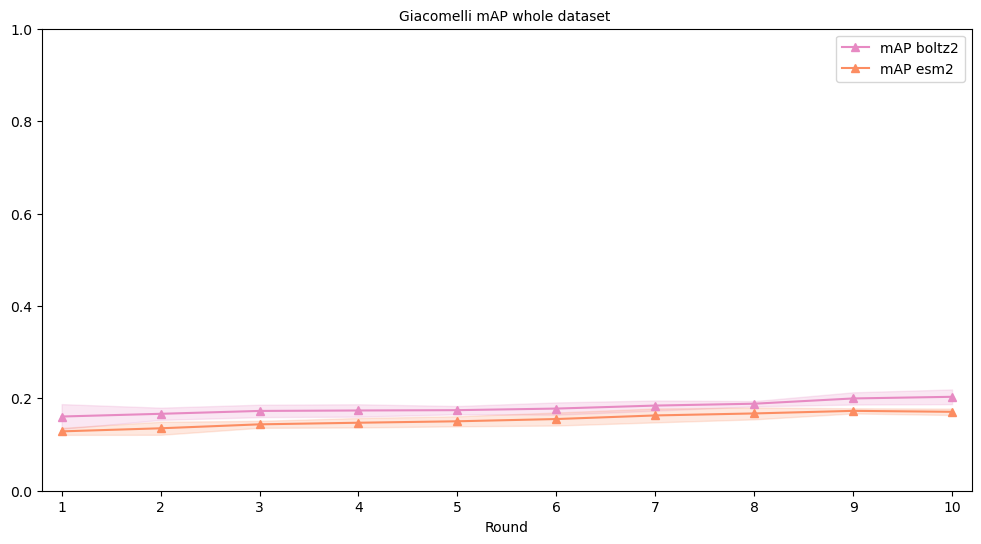

In [263]:
#mAP

color=sns.color_palette("Set2")


plt.figure(figsize=(12,6))
boltz_AP_mean = SAP_boltz2['mAP']
boltz_AP_std = SAP_boltz2['AP_std']
esm_AP_mean = SAP_esm2['mAP']
esm_AP_std = SAP_esm2['AP_std']

#Boltz data
plt.plot(range(1,11) , boltz_AP_mean , label='mAP boltz2', color=color[3] , marker='^')
plt.fill_between(range(1,11), boltz_AP_mean - boltz_AP_std , boltz_AP_mean + boltz_AP_std , color=color[3], alpha=0.2)


#ESM data
plt.plot(range(1,11) , esm_AP_mean , label='mAP esm2', color=color[1] , marker='^')
plt.fill_between(range(1,11), esm_AP_mean - esm_AP_std , esm_AP_mean + esm_AP_std , color=color[1], alpha=0.2)

#plt.errorbar(range(1,11), mean_df_boltz['mean_spearman'], yerr=mean_df_boltz['std_spearman'], label='Spearman@k boltz2', color=color[3], marker='^', capsize=3)
#plt.errorbar(range(1,11), mean_df_esm['mean_spearman'], yerr=mean_df_esm['std_spearman'], label='Spearman@k esm2', color=color[1], marker='o', capsize=3)

plt.title('Giacomelli mAP whole dataset ' , fontsize=10)
plt.xticks(range(1,11))
plt.xlabel('Round')
plt.legend()
plt.ylim(0,1)
plt.xlim(0.8 , 10.2)

plt.yticks([0,0.2,0.4,0.6,0.8,1])

plt.savefig('Giacomelli_mAP_whole_dataset' + '.png' , dpi=400)

plt.show()

In [ ]:
mean_spearman_booo = spearman_boltz_df.groupby('').agg(spearman_mean=('Spearman_rho' , 'mean') , spearman_std=('Spearman_rho' , 'std')).reset_index()

mean_spearman_booo['round_n'] = mean_spearman_booo[''].apply(lambda x: int(re.search(r'\d+', x).group()))

true_esm_sperman_mean

In [217]:
mean_spearman_booo['round_n'] = mean_spearman_booo[''].apply(lambda x: int(re.search(r'\d+', x).group()))

true_boltz_sperman_mean = mean_spearman_booo.sort_values(by='round_n')

true_boltz_sperman_mean

,,spearman_mean,spearman_std,round_n
0,Round1,0.270316,0.141769,1
2,Round2,0.219385,0.046390,2
3,Round3,0.181558,0.041597,3
4,Round4,0.184835,0.067153,4
5,Round5,0.178958,0.057877,5
6,Round6,0.183396,0.066912,6
7,Round7,0.202139,0.063768,7
8,Round8,0.212950,0.033034,8
9,Round9,0.229689,0.029695,9
1,Round10,0.231083,0.030136,10


In [218]:
true_esm_sperman_mean

,,spearman_mean,spearman_std,round_n
0,Round1,0.169239,0.068179,1
2,Round2,0.169425,0.028508,2
3,Round3,0.126616,0.109481,3
4,Round4,0.111702,0.125203,4
5,Round5,0.123506,0.107738,5
6,Round6,0.119634,0.122538,6
7,Round7,0.122388,0.118468,7
8,Round8,0.145518,0.104599,8
9,Round9,0.156481,0.087838,9
1,Round10,0.133148,0.091313,10


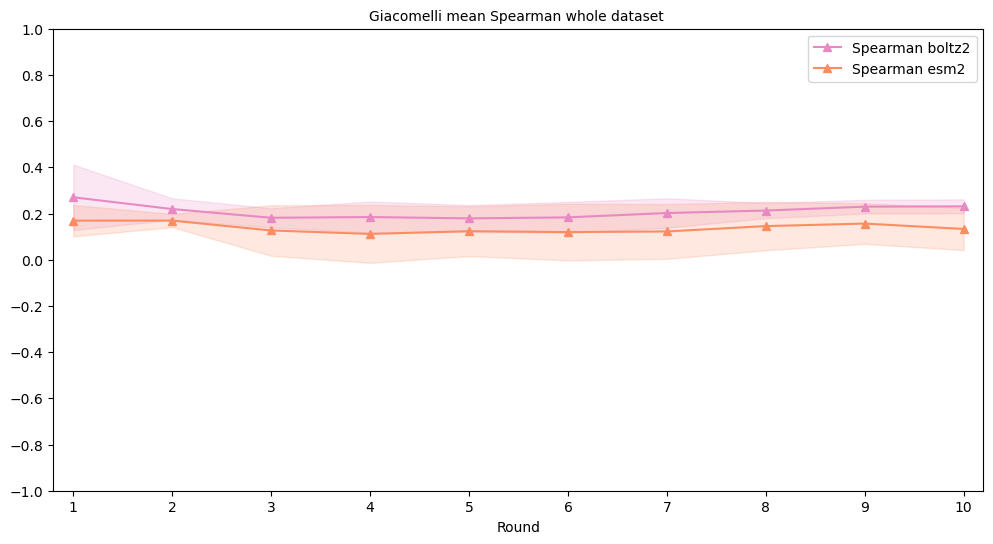

In [220]:
#spearman graph - lineplot


color=sns.color_palette("Set2")


plt.figure(figsize=(12,6))
boltz_spearman_mean = true_boltz_sperman_mean['spearman_mean']
boltz_spearman_std = true_boltz_sperman_mean['spearman_std']
esm_spearman_mean = true_esm_sperman_mean['spearman_mean']
esm_spearman_std = true_esm_sperman_mean['spearman_std']

#Boltz data
plt.plot(range(1,11) , boltz_spearman_mean , label='Spearman boltz2', color=color[3] , marker='^')
plt.fill_between(range(1,11), boltz_spearman_mean - boltz_spearman_std , boltz_spearman_mean + boltz_spearman_std , color=color[3], alpha=0.2)


#ESM data
plt.plot(range(1,11) , esm_spearman_mean , label='Spearman esm2', color=color[1] , marker='^')
plt.fill_between(range(1,11), esm_spearman_mean - esm_spearman_std , esm_spearman_mean + esm_spearman_std , color=color[1], alpha=0.2)

#plt.errorbar(range(1,11), mean_df_boltz['mean_spearman'], yerr=mean_df_boltz['std_spearman'], label='Spearman@k boltz2', color=color[3], marker='^', capsize=3)
#plt.errorbar(range(1,11), mean_df_esm['mean_spearman'], yerr=mean_df_esm['std_spearman'], label='Spearman@k esm2', color=color[1], marker='o', capsize=3)

plt.title('Giacomelli mean Spearman whole dataset ' , fontsize=10)
plt.xticks(range(1,11))
plt.xlabel('Round')
plt.legend()
plt.ylim(-1,1)
plt.xlim(0.8 , 10.2)
plt.yticks([-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])

#plt.yticks([0.4,0.6,0.8,1])

plt.savefig('Giacomelli_mean_spearman_whole_dataset' + '.png' , dpi=400)

plt.show()